In [1]:
#!pip install tensorflow

In [2]:
#!pip install Pillow

In [3]:
#!pip install scipy

In [4]:
#!pip install SimpleITK

In [5]:
#pip install imageio

In [6]:
import sys, pkgutil
print("Kernel Python:", sys.executable)



Kernel Python: C:\Users\hp\anaconda3\python.exe


In [7]:
# install GPU PyTorch (CUDA 11.8 build) 
# Cuz my GPU is NVIDIA 1050 TI
#%pip install --upgrade --index-url https://download.pytorch.org/whl/cu118 torch torchvision torchaudio

## Importing Libraries

In [8]:
import SimpleITK as sitk
import tensorflow
print(tensorflow.__version__)

2.20.0


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import random
import os, re
import glob
import imageio.v2 as imageio
import multiprocessing
import ipywidgets as widgets
import torch
import torchvision.transforms as T
import torchvision.models as tvm
import torch.nn as nn
import torch.nn.functional as F
import math


from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import display
from pathlib import Path
from collections import Counter 
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from tqdm import tqdm
from PIL import Image
import imageio.v2 as imageio
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

## Firstly setting up path

In [ ]:
ROOT = r"..\data\Image"
meta_csv  = r"..\data\Meta\lidc_slices.csv" 
IMG_PNG = [".png"]   

df = pd.read_csv(meta_csv)

# Labelling based on Maligancy as we get from Meta CSV
USE_MALIGNANCY_POLICY = True
BENIGN_MAX = 2.0
MALIGN_MIN = 4.0
INCLUDE_AMBIGUOUS = False      
NORMAL_BY = "is_clean"  
CLASS_NAMES = ["Normal", "Benign", "Malignant"]

## Global Hyperparameters Configuration

•**IMG_SIZE** : balances detail for lung textures

•**BATCH_SIZE** : maximizes throughput without on GPUs

•**LR** : for cosine annealing reduces LR over time for smoother, stronger convergence

•**WEIGHT_DECAY** : to reduce overfitting

•**NUM_WORKERS** : to avoid dataloader issues 

•**VAL_SIZE** : 20% for unbiased validation

•**SEED** : reproducibility for splits and training, default

•**PATIENCE** : stoppage for epochs or breaks

•**PRETRAINED** : ImageNet features for faster convert

•**FREEZE_BACKBONE_EPOCHS** : full fine-tune from the start

•**AUGMENT** : train-time transforms to boost generalization


In [11]:
IMG_SIZE = 256
BATCH_SIZE = 4 
EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4 
NUM_WORKERS = 0 
VAL_SIZE = 0.2
SEED = 42
PATIENCE = 5
PRETRAINED = True
FREEZE_BACKBONE_EPOCHS = 0
AUGMENT = True

SAVE_BEST_PATH = "best_mawnet3.pt"

In [12]:
print(df.head(20))

    patient_id  nodule_no  slice_no       original_image           mask_image  \
0            1          0         0  0001_NI000_slice000  0001_MA000_slice000   
1            1          0         1  0001_NI000_slice001  0001_MA000_slice001   
2            1          0         2  0001_NI000_slice002  0001_MA000_slice002   
3            1          0         3  0001_NI000_slice003  0001_MA000_slice003   
4            1          0         4  0001_NI000_slice004  0001_MA000_slice004   
5            1          0         5  0001_NI000_slice005  0001_MA000_slice005   
6            1          0         6  0001_NI000_slice006  0001_MA000_slice006   
7            1          0         7  0001_NI000_slice007  0001_MA000_slice007   
8            1          0         8  0001_NI000_slice008  0001_MA000_slice008   
9            1          0         9  0001_NI000_slice009  0001_MA000_slice009   
10           1          0        10  0001_NI000_slice010  0001_MA000_slice010   
11           1          0   

**Counting total number of images**

In [13]:
# Collect all PNG paths recursively
all_images = [
    os.path.join(root, f)
    for root, _, files in os.walk(ROOT)
    for f in files if f.lower().endswith('.png')
]

print(f"Total images found: {len(all_images)}")

Total images found: 59503


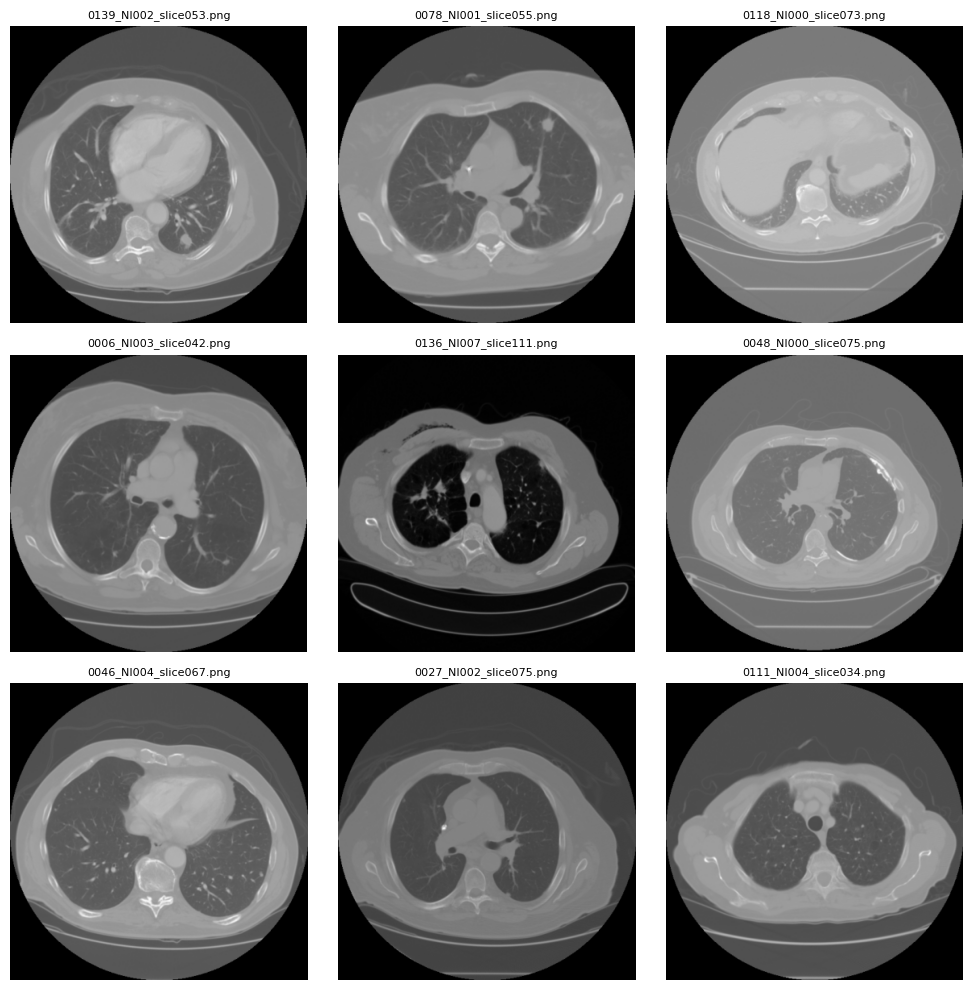

In [14]:
# Randomly selecting 9 samples for visualisation
sample_images = random.sample(all_images, 9)

# Displaying them 10 x 10
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images, 1):
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(img_path), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Viewing my system Core**

In [15]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 1050 Ti


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model training on:", device)

Model training on: cuda


# Data Parsing

### Label Mapping

Here, 

**find_all_images()** scan all images files with allowed extensions to quickly map images names and related paths for indexing

**guess_label_column()** detects the column containing class labels (e.g., cancer vs non-cancer)

**guess_image_key_column()** Identifies which DataFrame column holds image filenames or paths

**guess_patient_column()** the column that uniquely identifies patients or series

**norm_patient_token()** normalizes patient IDs into consistent 4-digit tokens for data consistency

**to_int_label():** converting string-based class names (benign, malignant) into integer labels (0, 1, 2)


In [17]:
def find_all_images(root_dir: str, exts):
    root = Path(root_dir)
    files = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
    index = {}
    for p in files:
        key1 = p.name.lower()
        key2 = str(p).replace(str(root)+os.sep, "").replace("\\", "/").lower()
        index[key1] = p
        index[key2] = p
    return index, files

def guess_label_column(df: pd.DataFrame):
    candidates = ["label","is_cancer","target","y","cancer","class","malignant","benign_malignant_normal"]
    for c in candidates:
        if c in df.columns: return c
    for c in df.columns:
        ser = df[c].dropna().astype(str).str.lower()
        if set(ser.unique()).issubset(set(["0","1","2"])):
            return c
    raise ValueError("No label column found. Add one of: label, is_cancer, target, y, cancer, class, malignant")

def guess_image_key_column(df: pd.DataFrame):
    candidates = ["filename","image","img","slice_name","slice_id","path","filepath","relative_path"]
    for c in candidates:
        if c in df.columns: return c
    for c in df.columns:
        col = df[c].astype(str)
        if col.str.contains(r"\.(?:png|jpe?g|bmp|tif)$", case=False, regex=True, na=False).any():
            return c
    return None

def guess_patient_column(df: pd.DataFrame):
    cand = ["patient","patient_id","patientid","pid","seriesuid","series_uid","study_id","LIDC_IDRI","lidc_id","lidc"]
    for c in cand:
        if c in df.columns: return c
    for c in df.columns:
        if df[c].astype(str).str.contains("LIDC-IDRI", case=False, regex=False).any():
            return c
    return None

def norm_patient_token(x) -> str:
    s = str(x).strip()
    m = re.search(r"(\d{1,4})(?!.*\d)", s)
    if m: return f"{int(m.group(1)):04d}"
    m = re.search(r"(\d+)", s)
    if m: return f"{int(m.group(1)):04d}"
    return None

def to_int_label(x):
    if isinstance(x, str):
        t = x.strip().lower()
        if t in ["normal","norm","0"]: return 0
        if t in ["benign","1","true","yes","pos","positive"]: return 1
        if t in ["malignant","2"]: return 2
        try: return int(float(t))
        except: return 0
    try: return int(x)
    except: return 0

In [18]:
def map_row_to_three_class(row):
    """
    Normal (0), Benign (1), Malignant (2)
      1) if NORMAL_BY column exists and is True
      2) else if malignancy == 0 Normal
      3) else use malignancy thresholds if USE_MALIGNANCY_POLICY
      4) else fall back to binary/is_cancer with Benign as 1 and Malignant as 2
    """
    # case 1: explicit normal flag
    if NORMAL_BY in row and str(row[NORMAL_BY]).strip().lower() in ["true", "1", "yes"]:
        return 0

    # case 2: malignancy column exactly 0
    if "malignancy" in row and pd.notna(row["malignancy"]) and float(row["malignancy"]) == 0.0:
        return 0

    # case 3: malignancy policy
    if USE_MALIGNANCY_POLICY and "malignancy" in row and pd.notna(row["malignancy"]):
        m = float(row["malignancy"])
        if m <= BENIGN_MAX:
            return 1
        elif m >= MALIGN_MIN:
            return 2
        else:
            # ambiguous ~3.0
            return None if not INCLUDE_AMBIGUOUS else 1

    return None

### Lung CT Slice Classification

In [19]:
#Handling 2D CT image slices
class SliceDataset(Dataset):
    def __init__(self, df, img_size=224, train=False, augment=True, tfms=None):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.train = bool(train) #training flag from source
        self.augment = bool(augment) #augment flag from source

        # normalized to the same distribution as the data they were trained on
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]

        tfms_list = []
        if self.train and self.augment:
            tfms_list += [
                transforms.RandomResizedCrop(img_size, scale=(0.80, 1.0)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.2),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.15, contrast=0.15),
                transforms.GaussianBlur(3),
            ]
        else:
            tfms_list += [transforms.Resize((img_size, img_size))]

        self.tfms = transforms.Compose(tfms_list + [
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

#loading the DataFrame to setup image transforms 
#data augmentation for training or resizing for validation/testing
    def __len__(self): return len(self.df)

#converting it to RGB to apply transformations
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = Path(str(row["path"]))
        with Image.open(p) as im:
            im = im.convert("RGB")
            img = np.array(im).astype(np.float32) / 255.0  # convert to np array 
    
        # apply light augmentations
        if getattr(self, "train", False):
            if np.random.rand() < 0.5:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() < 0.3:  # small rotation
                angle = np.random.uniform(-7, 7)
                from skimage import transform as skimage_transform
                img = skimage_transform.rotate(
                    img, angle, mode="edge", preserve_range=True
                ).astype(np.float32)
            if np.random.rand() < 0.3: 
                g = np.random.uniform(0.9, 1.1)
                img = np.power(np.clip(img, 0, 1), g).astype(np.float32)
    
        # convert back to PIL for torchvision
        img = Image.fromarray((img * 255).astype(np.uint8))
        x = self.tfms(img)
    
        y = int(row["label"])
        return x, y

**Source:** https://pytorch.org/vision/stable/models.html#classification and
Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet Classification with Deep Convolutional Neural Networks (AlexNet). NeurIPS 2012

And also from, https://www.kaggle.com/code/kstensbo/deep-learning-for-land-cover-classification to use Albumentations-style randomness.

# Using RestNet Classifier

In [20]:
#ResNet classifier
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=2, arch="resnet34", pretrained=True, dropout=0.2):
        super().__init__()
        # torchvision weights API
        if arch == "resnet18":
            try:
                base = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            except Exception:
                base = tvm.resnet18(pretrained=pretrained)
        elif arch == "resnet50":
            try:
                base = tvm.resnet50(weights=tvm.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
            except Exception:
                base = tvm.resnet50(pretrained=pretrained)
        else:  # resnet34 default
            try:
                base = tvm.resnet34(weights=tvm.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)
            except Exception:
                base = tvm.resnet34(pretrained=pretrained)

        in_feats = base.fc.in_features
        base.fc = nn.Identity()       
        self.backbone = base
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)               # [B, in_feats]
        logits = self.head(feats)              # [B, 3]
        return logits, feats                   # keep tuple API like MAW-Net

### Class Balance

In [21]:
# Frow above Label Mapping function getting filename and path
index, files = find_all_images(ROOT, IMG_PNG)
print(f"Found {len(files)} image files.")

df = pd.read_csv(meta_csv)
label_col = guess_label_column(df)
img_col = guess_image_key_column(df)
pat_col = guess_patient_column(df)
print("Label column:", label_col)
print("Patient column:", pat_col)

Found 59503 image files.
Label column: is_cancer
Patient column: patient_id


In [22]:
def norm_key(s: str):
    """
    for lowercases and standardizing slashes for CSV paths
    """
    s1 = str(s).split("|")[-1].replace("\\","/").lower()
    return s1.split("/")[-1] if "." in Path(s1).name else s1

paths, labels = [], []
skipped = 0

if img_col is not None:
    """
    getting CSV image via full/filename keys
    and counting skipped to spot metadata from CSV to avoid mismatch
    """
    # image-level mapping via CSV filename column
    for _, row in df.iterrows():
        key = norm_key(row[img_col])
        p = index.get(key) or index.get(Path(key).name)
        if p is None:
            skipped += 1
            continue
        if Path(p).parent.name.endswith("0071"):  # keep your known-missing
            skipped += 1
            continue

        lab3 = map_row_to_three_class(row)
        if lab3 is None:
            skipped += 1
            continue

        paths.append(str(p))
        labels.append(int(lab3))

else:
    # patient-level mapping then fan-out to slices (fallback)
    tmp = df.copy()
    tmp["pat_norm"] = tmp[pat_col].apply(norm_patient_token) if pat_col in df.columns else None

    patient_labels = {}
    for _, row in tmp.dropna(subset=["pat_norm"]).iterrows():
        lab3 = map_row_to_three_class(row)
        if lab3 is None:
            continue
        patient_labels[row["pat_norm"]] = lab3

    for p in files:
        pat = norm_patient_token(p.parent.name)
        if pat is None or pat == "0071" or pat not in patient_labels:
            skipped += 1
            continue
        paths.append(str(p))
        labels.append(int(patient_labels[pat]))

In [23]:
#patient labels to all slices
data = pd.DataFrame({"path": paths, "label": labels})
data["group"] = data["path"].apply(lambda s: Path(s).parent.name)

classes = sorted(list(set(labels)))
num_classes = 2  # force multiclass evaluation to match model
if 0 not in classes:
    print("warning: class 0 (Normal) not present in this split")

#Printing checks
print(f"Usable slices: {len(data)} | Skipped: {skipped} | Classes: {classes}")

groups = data["group"].values
splitter = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=SEED)
train_idx, val_idx = next(splitter.split(data, groups=groups))
train_df = data.iloc[train_idx].reset_index(drop=True)
val_df   = data.iloc[val_idx].reset_index(drop=True)

def bal(df, name):
    """
    reporting class distribution in train/val to catch class imbalance early
    to mitigate error
    """
    c = Counter(df["label"].tolist()); total = len(df)
    print(f"{name}: {total} | balance:", {k: f"{v} ({v/total:.1%})" for k,v in c.items()})
bal(train_df, "Train"); bal(val_df, "Val")

Usable slices: 54827 | Skipped: 4676 | Classes: [1, 2]
Train: 44071 | balance: {2: '24778 (56.2%)', 1: '19293 (43.8%)'}
Val: 10756 | balance: {2: '5708 (53.1%)', 1: '5048 (46.9%)'}


In [24]:
classes_present = sorted(train_df["label"].unique().tolist() + val_df["label"].unique().tolist())
classes_present = sorted(set(classes_present))

if classes_present == [1, 2]:
    print("Binary mode: remapping {1,2} -> {0,1}")
    remap = {1: 0, 2: 1}
    train_df["label"] = train_df["label"].map(remap)
    val_df["label"]   = val_df["label"].map(remap)
    CLASS_NAMES = ["Benign", "Malignant"]
    num_classes = 2
else:
    num_classes = 3  # keep 3-class if class 0 exists

Binary mode: remapping {1,2} -> {0,1}


In [25]:
# data columns: path, label, group (parent folder = patient)
print("Slices:", len(data), "| Pos slices:", int((data['label']==1).sum()))

pat = (data.groupby('group')['label']
           .mean().round().astype(int).reset_index(name='pat_label'))
print("Patients:", len(pat))
print("Pos patients:", int((pat['pat_label']==1).sum()))
print(pat['pat_label'].value_counts(dropna=False))

Slices: 54827 | Pos slices: 24341
Patients: 154
Pos patients: 57
pat_label
2    97
1    57
Name: count, dtype: int64


## Balanced dataloaders with weighted sampling

In [26]:
class BalancedBatchSampler(Sampler):
    """
    added new helper class to balance batches
    """
    def __init__(self, labels, batch_size=32):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.by_class = defaultdict(list)
        for i, y in enumerate(self.labels):
            self.by_class[int(y)].append(i)
        self.classes = sorted(self.by_class.keys())
        self.per_class = max(1, batch_size // max(1, len(self.classes)))

    def __iter__(self):
        pools = {k:list(v) for k,v in self.by_class.items()}
        for k in pools: random.shuffle(pools[k])
        total = len(self.labels); made = 0
        while made < total:
            batch = []
            for k in self.classes:
                need = self.per_class
                if len(pools[k]) < need:
                    add = random.choices(self.by_class[k], k=need)
                else:
                    add = [pools[k].pop() for _ in range(need)]
                batch.extend(add)
            if len(batch) > self.batch_size:
                batch = batch[:self.batch_size]
            made += len(batch)
            yield batch

    def __len__(self):
        return math.ceil(len(self.labels) / self.batch_size)

In [27]:
#Wrapping tran and validation df and applying augmentation on training
train_ds = SliceDataset(train_df, img_size=IMG_SIZE, train=True,  augment=AUGMENT)
val_ds   = SliceDataset(val_df,   img_size=IMG_SIZE, train=False, augment=False)

# compute inverse-frequency class weights from the training split
class_counts = Counter(train_df["label"].tolist())
total = sum(class_counts.values())

# From above balanced set
sample_weights = [total / class_counts[row["label"]] for _, row in train_df.iterrows()]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# create balanced batch sampler for training
train_sampler = BalancedBatchSampler(train_df["label"].tolist(), batch_size=BATCH_SIZE)

#Using "PyTorch loaders" with pinned memory as my GPU for training use
train_dl = DataLoader(train_ds, batch_sampler=train_sampler,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

In [28]:
# indicating model capacity
model = ResNetClassifier(num_classes=num_classes, arch="resnet34", pretrained=PRETRAINED, dropout=0.2).to(device)
_cc = Counter(train_df["label"].tolist())
_total = sum(_cc.values())

# building per-class weights in index order [0,1,2]
w = np.array([ _total / max(1, _cc.get(k, 1)) for k in range(num_classes) ], dtype=float)
w = w / max(w.mean(), 1e-8)  # normalize to mean here
w = np.clip(w, 0.5, 1.5)
_weight_tensor = torch.tensor(w, dtype=torch.float32, device=device)

# weighted cross-entropy with light label smoothing
criterion = nn.CrossEntropyLoss(weight=_weight_tensor, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, min_lr=LR*0.01)


# fine-tune all
for p in model.parameters(): p.requires_grad = True

total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Trainable Parameters: {total_params:.2f}M")

Trainable Parameters: 21.29M


## Training Monitor, Validation Metrics

In [29]:
def live_plot_init():
    """
    updating each epoch to spot an overfitting
    """
    plt.close("all")
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.set_title("Training Progress")
    ax.set_xlabel("Epoch")
    (l_loss,) = ax.plot([], [], label="Train Loss")
    (l_acc,)  = ax.plot([], [], label="Val Acc")
    (l_f1,)   = ax.plot([], [], label="Val F1")
    ax.legend(loc="best")
    return fig, ax, l_loss, l_acc, l_f1

def live_plot_update(ax, l_loss, l_acc, l_f1, losses, accs, f1s):
    from IPython.display import clear_output, display #Must add
    xs = list(range(1, len(losses)+1))
    l_loss.set_data(xs, losses)
    l_acc.set_data(xs, accs)
    l_f1.set_data(xs, f1s)
    ax.relim(); ax.autoscale_view()
    clear_output(wait=True); display(ax.figure)

def evaluate_cls_full(model, loader, num_classes):
    """
    computes validation metrics
    - binary (num_classes==2): best threshold by F1
    - multiclass (num_classes>=3): argmax + macro metrics
    returns: (metrics_dict, probs_array)
    """
    model.eval()
    y_true, y_prob = [], []
    from sklearn.preprocessing import label_binarize

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                xb, yb = batch[0], batch[1]
            else:
                xb, yb = loader.dataset[batch]  # rare fallback

            if not torch.is_tensor(xb): xb = torch.as_tensor(xb)
            if not torch.is_tensor(yb): yb = torch.as_tensor(yb)

            xb = xb.to(device)
            yb = yb.long().to(device)

            out = model(xb)
            logits = out[0] if isinstance(out, tuple) else out

            if num_classes == 2:
                # 2 logits (preferred) → softmax[:,1]; 1 logit → sigmoid
                if logits.ndim == 2 and logits.shape[1] == 2:
                    probs = torch.softmax(logits, dim=1)[:, 1]
                else:
                    probs = torch.sigmoid(logits.squeeze(1))
                y_prob.extend(probs.detach().cpu().numpy().reshape(-1))
            else:
                probs = torch.softmax(logits, dim=1)
                y_prob.extend(probs.detach().cpu().numpy())

            y_true.extend(yb.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    metrics = {}

    if num_classes == 2:
        # threshold sweep to maximize F1
        ths = np.linspace(0.05, 0.95, 181)
        f1s = []
        for t in ths:
            y_pred = (y_prob >= t).astype(int)
            f1s.append(f1_score(y_true, y_pred, average="binary", zero_division=0))
        best_t = float(ths[int(np.argmax(f1s))])
        y_pred = (y_prob >= best_t).astype(int)

        metrics["best_th"]   = best_t
        metrics["acc"]       = float(accuracy_score(y_true, y_pred))
        metrics["f1"]        = float(f1_score(y_true, y_pred, average="binary", zero_division=0))
        metrics["f1_macro"]  = metrics["f1"]  # so loop can read f1_macro uniformly
        try:
            metrics["auc"] = float(roc_auc_score(y_true, y_prob))
        except Exception:
            metrics["auc"] = float("nan")
        try:
            metrics["mcc"] = float(matthews_corrcoef(y_true, y_pred))
        except Exception:
            metrics["mcc"] = float("nan")

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        metrics["cm"] = cm.tolist()
        return metrics, y_prob

    else:
        # multiclass path
        y_pred = y_prob.argmax(axis=1)
        metrics["acc"]        = float(accuracy_score(y_true, y_pred))
        metrics["f1_macro"]   = float(f1_score(y_true, y_pred, average="macro",    zero_division=0))
        metrics["f1_weighted"]= float(f1_score(y_true, y_pred, average="weighted", zero_division=0))

        try:
            y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
            metrics["auc"] = float(roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr"))
        except Exception:
            metrics["auc"] = float("nan")

        try:
            metrics["mcc"] = float(matthews_corrcoef(y_true, y_pred))
        except Exception:
            metrics["mcc"] = float("nan")

        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        metrics["cm"] = cm.tolist()
        return metrics, y_prob

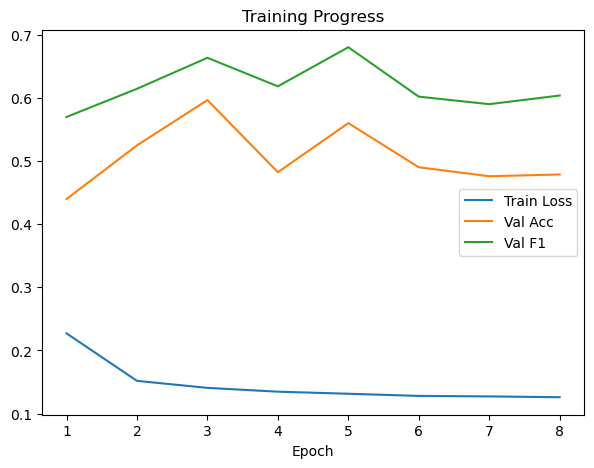

epoch 9/20:   5%|██▊                                                   | 567/11018 [02:39<52:04,  3.34it/s, loss=0.116]

In [ ]:
train_losses, val_accs, val_f1s = [], [], []
best_acc, best_state = -1, None
best_f1 = -1.0
no_improve = 0
PATIENCE = 5

fig, ax, l_loss, l_acc, l_f1 = live_plot_init()

for ep in range(1, EPOCHS+1):
    model.train()
    running, n = 0.0, 0

    pbar = tqdm(train_dl, desc=f"epoch {ep}/{EPOCHS}")
    for batch in pbar:
        #DataLoader already from above cell
        if isinstance(batch, (list, tuple)) and len(batch) >= 2 and torch.is_tensor(batch[0]) and torch.is_tensor(batch[1]):
            xb, yb = batch[0], batch[1]

        #fetch from dataset and stack
        elif isinstance(batch, (list, tuple)) and len(batch) > 0 and all(
            isinstance(b, (int, np.integer, torch.Tensor)) for b in batch
        ):
            idxs = [int(b.item()) if torch.is_tensor(b) else int(b) for b in batch]
            samples = [train_ds[i] for i in idxs]  # each sample: (x, y, *rest)
            xs = [s[0] for s in samples]
            ys = [int(s[1]) for s in samples]
            # ensure tensors with batch dimension
            xb = torch.stack([torch.as_tensor(x) for x in xs], dim=0)
            yb = torch.tensor(ys, dtype=torch.long)

        # fetch sample add batch dim
        elif isinstance(batch, (int, np.integer)) or (torch.is_tensor(batch) and batch.dim() == 0):
            idx = int(batch.item()) if torch.is_tensor(batch) else int(batch)
            x1, y1, *_ = train_ds[idx]
            xb = torch.as_tensor(x1).unsqueeze(0)
            yb = torch.tensor([int(y1)], dtype=torch.long)

        else:
            try:
                xb, yb = batch[0], batch[1]
            except Exception as e:
                raise RuntimeError(f"Unhandled batch type/shape: {type(batch)}; error: {e}")

        # move to device & correct dtypes
        xb = xb.to(device, non_blocking=True)
        yb = yb.long().to(device, non_blocking=True)

        # forward (supports (logits, features) or just logits)
        out = model(xb)
        logits = out[0] if isinstance(out, tuple) else out

        # loss/backprop
        loss = criterion(logits, yb)
        if not torch.isfinite(loss):
            continue

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        # book-keeping
        running += float(loss) * xb.size(0)
        n += xb.size(0)
        pbar.set_postfix(loss=float(loss))

    # end epoch
    epoch_loss = running / max(n, 1)
    train_losses.append(epoch_loss)

    # validation (force multiclass=3)
    metrics, _ = evaluate_cls_full(model, val_dl, num_classes)
    acc = float(metrics.get("acc", 0.0))
    f1  = float(metrics.get("f1_macro", metrics.get("f1", 0.0)))
    val_accs.append(acc)
    val_f1s.append(f1)

    #early stopping
    if f1 > best_f1 + 1e-4:
        best_f1 = f1
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= PATIENCE:
        print(f"early stop at epoch {ep} (no val F1 improvement for {PATIENCE} epochs)")
        break

    if scheduler is not None:
        scheduler.step(f1) 

    # live plot
    live_plot_update(ax, l_loss, l_acc, l_f1, train_losses, val_accs, val_f1s)

    # save best by accuracy
    if acc > best_acc:
        best_acc = acc
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": ep,
            "metrics": metrics,
        }
        torch.save(best_state, SAVE_BEST_PATH)

print(f"best val acc = {best_acc:.4f}")